In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandahouse as ph
import datetime
from datetime import timedelta
from operator import attrgetter
%matplotlib inline

## Сколько заказов в месяц, в среднем, не доставляется по разным причинам? Вывести детализацию по причинам.

Будем использовать метод resample. Для этого еще раз проверим типы данных в нашем датафрейме и переведем колонку подтверждения оплаты (order_purchase_timestamp) в индекс.

In [19]:
customers_items.dtypes
# Колонки с указанием даты и времени переведены в необходимые типы данных

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [20]:
# Переведем колнку в индекс
customers_items = customers_items.set_index('order_purchase_timestamp')

In [21]:
delivered_orders = customers_items.loc[customers_items.order_delivered_customer_date.notna()]\
                                  .query('order_status == "delivered"')\
                                  .resample(rule='M')\
                                  .order_id.count().reset_index()\
                                  .rename(columns={'order_purchase_timestamp':'month','order_id':'value_delivered_orders'})

# 1. Отобрали только те заказы, которые были доставлены
# 2. Перевели временные данные к концу месяца (чтобы перед глазами было видно количество дней в месяце)
# 3. Посчитали количество заказов (применили reset_index для возможности переименования колонок)
# 4. Для удобства чтения переименовали колонки

In [22]:
# Проверим себя. Если есть время доставки, то и статус заказа должен быть 'delivered'

customers_items.loc[customers_items.order_delivered_customer_date.notna()]\
               .query('order_status == "delivered"')\
               .order_status.value_counts()

# Есть одно замечание. Доп. фильтрация по статусу 'delivered' не показывает отмененные заказы (статус 'canceled').
# Статус 'canceled' вполне вероятен, потому что от товара могли отказаться после получения.

delivered    96470
Name: order_status, dtype: int64

In [23]:
# найдем количество не доставленных товаров

not_delivered_orders = customers_items.loc[customers_items.order_delivered_customer_date.isna()]\
                                  .query('order_status != "delivered"')\
                                  .resample(rule='M')\
                                  .order_id.count().reset_index()\
                                  .rename(columns={'order_purchase_timestamp':'month','order_id':'value_not_delivered_orders'})

# Отобрали только те заказы, которые не были доставлены
# Повторили действия из предыдущего шага, изменив название количетва не доставленных заказов

In [24]:
# Снова проверим себя. Исходя из нашего фильтра, у нас не должно быть заказов со статусом 'delivered'

customers_items.loc[customers_items.order_delivered_customer_date.isna()]\
               .query('order_status != "delivered"')\
               .order_status.value_counts()

# Но он почему-то есть (если не фильтровать order_status != "delivered"), нужно разобраться, почему?
# Возможно это просто техническая ошибка и товары на самом деле доставлены.
# Мы тоже будем считать, что товары доставлены.

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

In [25]:
not_delivered_orders.value_not_delivered_orders.mean()

113.73076923076923

**Ответ: 113.73076923076923 заказов в месяц в среднем не доставляется по разным причинам**

Выведем детализацию по причинам 

In [26]:
not_delivered_by_month = customers_items.loc[customers_items.order_delivered_customer_date.isna()]\
                                        .query('order_status != "delivered"')\
                                        .resample(rule='M')\
                                        .order_status.value_counts()\
                                        .to_frame()\
                                        .rename(columns={'order_status':'value'})\
                                        .reset_index()\
                                        .rename(columns={'order_purchase_timestamp':'month'}) 

# Выбираем не доставленные заказы
# Переводим дату доставки в месяца и переименовываем столбец
# Считаем количество заказов для каждого статуса и переименовываем столбец
# Сбрасываем индексы

not_delivered_by_month

,month,order_status,value
0,2016-09-30,canceled,2
1,2016-09-30,shipped,1
2,2016-10-31,canceled,19
3,2016-10-31,invoiced,18
4,2016-10-31,shipped,8
...,...,...,...
108,2018-08-31,invoiced,23
109,2018-08-31,unavailable,7
110,2018-09-30,canceled,15
111,2018-09-30,shipped,1


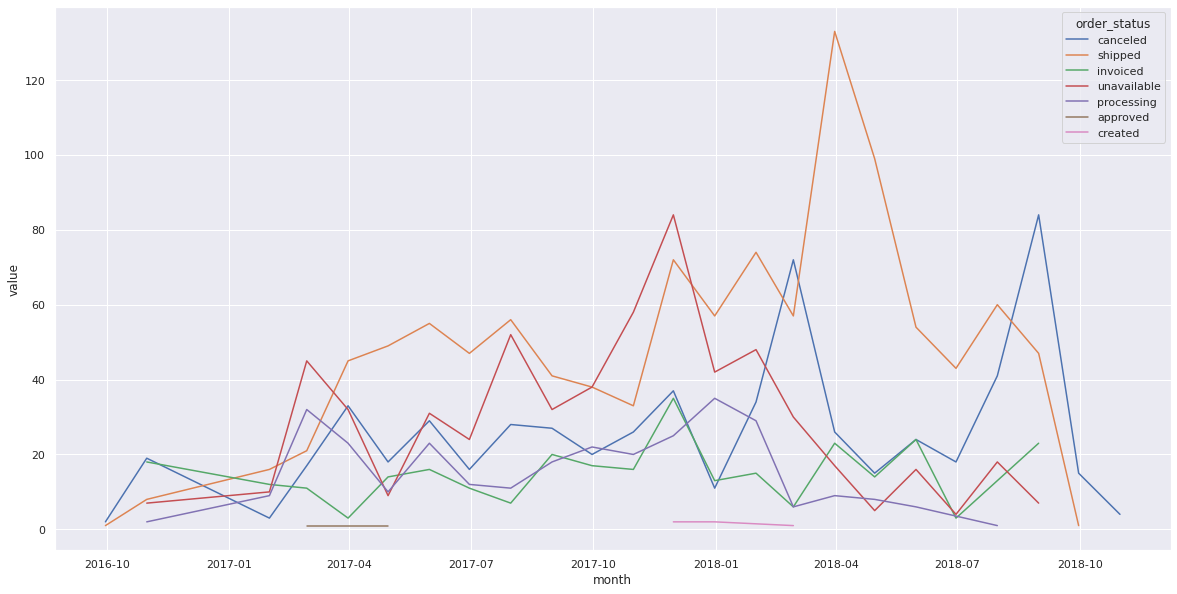

In [27]:
# Визуализируем результат
sns.set(rc={'figure.figsize': (20,10)})
sns.lineplot(x=not_delivered_by_month.month, y=not_delivered_by_month.value, hue=not_delivered_by_month.order_status)

In [28]:
# Среднее количество не доставленных заказов по причинам
not_delivered_by_month.groupby('order_status', as_index=False)\
                      .agg({'value':'mean'})\
                      .round(2)

,order_status,value
0,approved,1.00
1,canceled,25.79
2,created,1.67
3,invoiced,14.95
4,processing,15.84
5,shipped,48.13
6,unavailable,29.00
